# Apple and Microsoft Closing Price Prediction

### Contents
 1. Data Import
 2. Data Exploration
 3. Scaling and Splitting Data for Modelling
 4. LSTM Closing Price Prediction
 
## 1. Data Import
I first import the necessary libraries and the past year of trading data for Apple and Microsoft from Yahoo Finance.

In [1]:
#libraries import
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pandas_datareader import data as web
import yfinance as yf

from datetime import datetime

In [2]:
#download annual stock data for apple and microsoft
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

globals()['AAPL'] = yf.download('AAPL', start, end)
globals()['MSFT'] = yf.download('MSFT', start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
AAPL.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-14,151.449997,154.119995,150.100006,150.619995,149.713074,108732100
2022-03-15,150.899994,155.570007,150.380005,155.089996,154.156174,92964300
2022-03-16,157.050003,160.000000,154.460007,159.589996,158.629074,102300200
2022-03-17,158.610001,161.000000,157.630005,160.619995,159.652847,75615400
2022-03-18,160.509995,164.479996,159.759995,163.979996,162.992645,123511700


## 2. Data Exploration
In this section I explore a range of daily visualizations of the data, including closing price (with and without rolling means), sales volume, and calculated daily return (percent change from previous day). I then look at distributions of the daily returns for each company and correlations between both companies for scatter plots of daily returns and closing price. Finally, I compare the means (expected returns) and standard deviations (risk) of both companies.

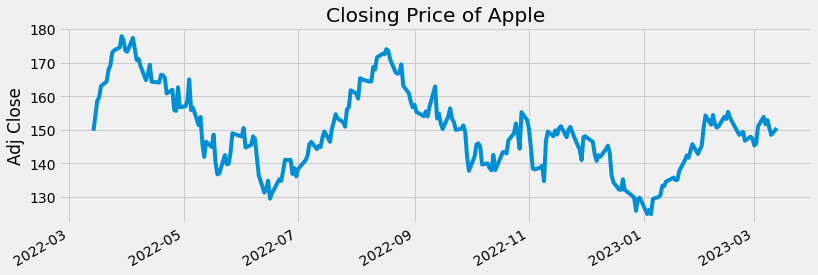

In [4]:
#apple closing timeseries plot
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 4))

AAPL['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title("Closing Price of Apple")

plt.show()

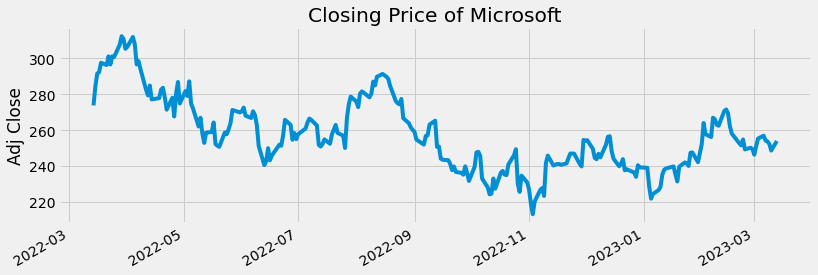

In [5]:
#microsoft closing timeseries plot
plt.figure(figsize=(12, 4))

MSFT['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title("Closing Price of Microsoft")

plt.show()

Both companies follow similar annual pattern, with closing price peaks around April and August and valleys in June, November, and January. Apple appears to be at a similar closing price around 150 to last March, whereas Microsoft has declined from about 275 to 250.

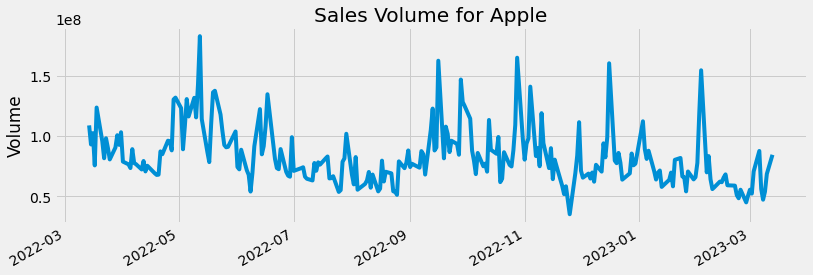

In [6]:
#apple sales volume plot
plt.figure(figsize=(12, 4))
AAPL['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume for Apple")

plt.show()

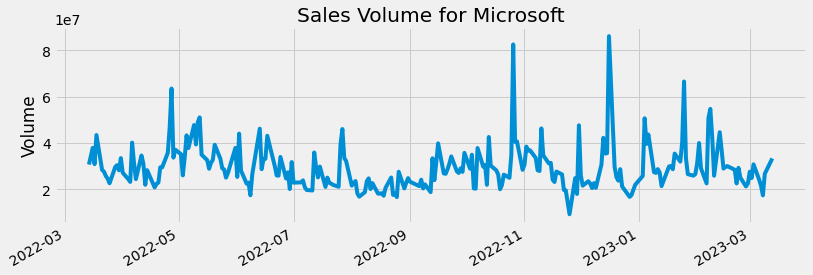

In [7]:
#microsoft sales volume plot
plt.figure(figsize=(12, 4))
MSFT['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume for Microsoft")

plt.show()

There appear to be weekly patterns in sales volume for both companies, so I will explore which days of the week tend to have the highest sales.

In [37]:
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume,day_of_week
count,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02,251.000000
mean,150.085618,152.198884,148.189482,150.285219,149.787283,8.291446e+07,2.043825
std,11.895390,11.830876,11.948605,11.944130,11.779349,2.372075e+07,1.395017
min,126.010002,127.769997,124.169998,125.019997,124.829399,3.519590e+07,0.000000
25%,142.110001,143.854996,139.949997,142.464996,141.973427,6.781880e+07,1.000000
50%,148.869995,150.919998,147.240005,149.350006,148.910004,7.785210e+07,2.000000
75%,156.845001,159.090004,154.435005,156.849998,156.238129,9.148545e+07,3.000000
max,178.550003,179.610001,176.699997,178.960007,177.882462,1.826020e+08,4.000000


In [36]:
#check which days have sales above 1.5e+08
AAPL['day_of_week'] = AAPL.index.to_series().dt.dayofweek
check_days = AAPL[AAPL['Volume'] > 150000000]
check_days

,Open,High,Low,Close,Adj Close,Volume,day_of_week
Date,,,,,,,
2022-05-12,142.770004,146.199997,138.800003,142.559998,141.909821,182602000,3
2022-09-16,151.210007,151.350006,148.369995,150.699997,150.221069,162278800,4
2022-10-28,148.199997,157.500000,147.820007,155.740005,155.245056,164762400,4
2022-12-16,136.690002,137.649994,133.729996,134.509995,134.304932,160156900,4
2023-02-03,148.029999,157.380005,147.830002,154.500000,154.264465,154357300,4


In [44]:
#check which days have sales above 9.1e+07 or above the third quartile
check_days = AAPL[AAPL['Volume'] > 9.148545e+07]
print(AAPL['day_of_week'].unique())
print(check_days['day_of_week'].value_counts())

[0 1 2 3 4]
4    15
3    14
2    12
0    11
1    11
Name: day_of_week, dtype: int64


In [45]:
MSFT.describe()

,Open,High,Low,Close,Adj Close,Volume,day_of_week
count,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02,251.000000
mean,258.915179,262.183306,255.621434,259.002948,257.522723,2.948336e+07,2.043825
std,21.097125,21.007324,20.846315,21.117438,20.513875,9.740948e+06,1.395017
min,217.550003,220.410004,213.429993,214.250000,213.114120,9.200800e+06,0.000000
25%,243.160004,245.305000,240.264999,242.354996,241.440262,2.284655e+07,1.000000
50%,256.390015,259.720001,252.770004,255.139999,254.502548,2.785290e+07,2.000000
75%,272.935013,275.865005,268.669998,272.295013,270.561646,3.343830e+07,3.000000
max,313.910004,315.950012,311.579987,315.410004,312.345764,8.610200e+07,4.000000


In [46]:
#check which days have sales above 6e+07
MSFT['day_of_week'] = MSFT.index.to_series().dt.dayofweek
check_days = MSFT[MSFT['Volume'] > 60000000]
check_days

,Open,High,Low,Close,Adj Close,Volume,day_of_week
Date,,,,,,,
2022-04-27,282.100006,290.970001,279.160004,283.220001,280.468506,63477700,2
2022-10-26,231.169998,238.300003,230.059998,231.320007,230.093628,82543200,2
2022-12-16,248.550003,249.839996,243.509995,244.690002,244.078659,86102000,4
2023-01-25,234.479996,243.300003,230.899994,240.610001,240.008850,66526600,2


In [47]:
#check which days have sales above 9.1e+07 in the 4th quartile
check_days = MSFT[MSFT['Volume'] > 3.343830e+07]
print(MSFT['day_of_week'].unique())
print(check_days['day_of_week'].value_counts())

[0 1 2 3 4]
4    17
3    14
2    13
1    12
0     7
Name: day_of_week, dtype: int64


There is in fact a tendency for sales volume to increase throughout the week, with the largest number of days in the 4th quartile occuring on Fridays for both companies. However, the very largest sales volume days were most often Wednesdays for Microsoft.

In [48]:
#Create Moving Averages for Ajd Close
ma_day = [10, 20, 50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    AAPL[column_name] = AAPL['Adj Close'].rolling(ma).mean()
    MSFT[column_name] = MSFT['Adj Close'].rolling(ma).mean()

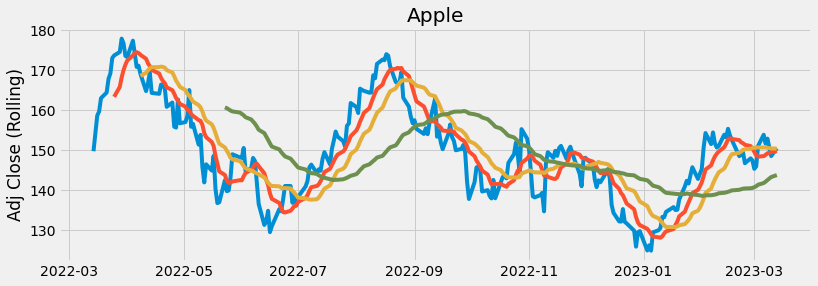

In [49]:
#Plot AAPL moving averages
plt.figure(figsize=(12, 4))
plt.plot(AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']])
plt.ylabel('Adj Close (Rolling)')
plt.xlabel(None)
plt.title('Apple')

plt.show()

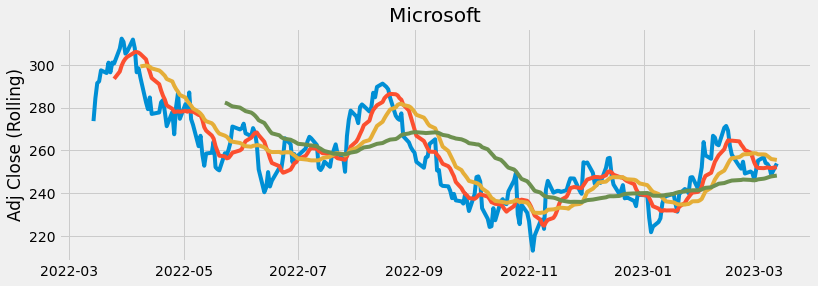

In [50]:
#Plot MSFT moving averages
plt.figure(figsize=(12, 4))
plt.plot(MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']])
plt.ylabel('Adj Close (Rolling)')
plt.xlabel(None)
plt.title('Microsoft')

plt.show()

In [51]:
#Determine daily return (pct change)
AAPL['Daily Return'] = AAPL['Adj Close'].pct_change()
MSFT['Daily Return'] = MSFT['Adj Close'].pct_change()

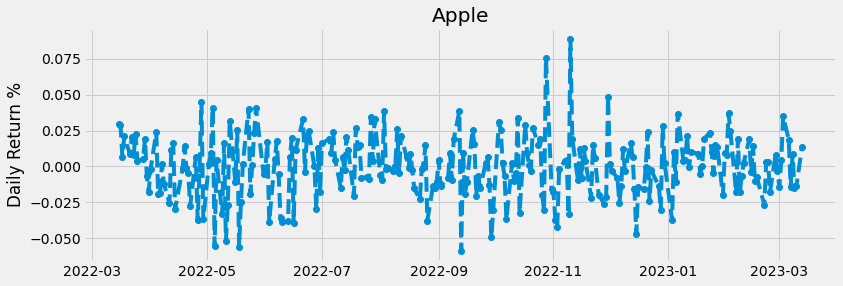

In [52]:
#Plot AAPL daily return
plt.figure(figsize=(12, 4))
plt.plot(AAPL['Daily Return'], linestyle='--', marker='o')
plt.ylabel('Daily Return %')
plt.xlabel(None)
plt.title('Apple')

plt.show()

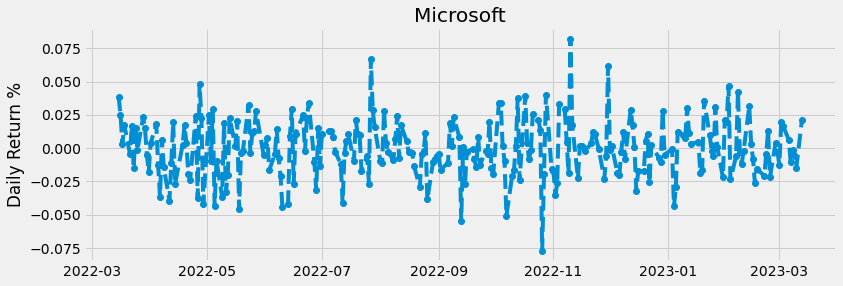

In [53]:
#Plot MSFT daily return
plt.figure(figsize=(12, 4))
plt.plot(MSFT['Daily Return'], linestyle='--', marker='o')
plt.ylabel('Daily Return %')
plt.xlabel(None)
plt.title('Microsoft')

plt.show()

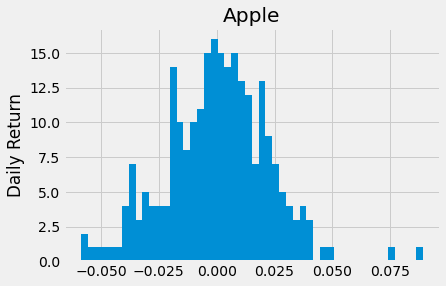

In [56]:
#Historgram of AAPL daily return
AAPL['Daily Return'].hist(bins=50)
plt.ylabel('Daily Return')
plt.title('Apple')
plt.show()

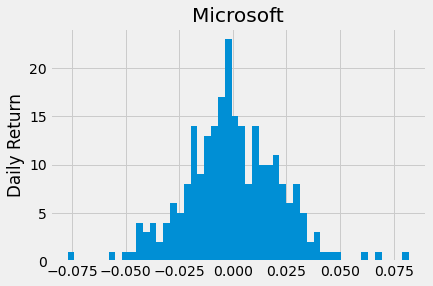

In [57]:
#Historgram of MSFT daily return
MSFT['Daily Return'].hist(bins=50)
plt.ylabel('Daily Return')
plt.title('Microsoft')
plt.show()

In [59]:
#Distributions
AAPL['Daily Return'].describe()

count    250.000000
mean       0.000263
std        0.022093
min       -0.058680
25%       -0.014154
50%        0.001444
75%        0.014767
max        0.088975
Name: Daily Return, dtype: float64

In [60]:
MSFT['Daily Return'].describe()

count    250.000000
mean      -0.000061
std        0.021956
min       -0.077156
25%       -0.013685
50%       -0.001767
75%        0.013584
max        0.082268
Name: Daily Return, dtype: float64

We can see that the average daily return is slightly positive for Apple and slightly negative for Microsoft, and each have similar standard deviation.

In [65]:
#Concat both companies for comparison of daily returns
closing_df = pd.concat({'AAPL': AAPL['Adj Close'], 'MSFT': MSFT['Adj Close']}, axis=1)

closing_df.head()

,AAPL,MSFT
Date,,
2022-03-14,149.713074,273.754364
2022-03-15,154.156174,284.360352
2022-03-16,158.629074,291.529999
2022-03-17,159.652847,292.351929
2022-03-18,162.992645,297.511322


In [66]:
tech_rets = closing_df.pct_change()
tech_rets.head()

,AAPL,MSFT
Date,,
2022-03-14,NaN,NaN
2022-03-15,0.029677,0.038743
2022-03-16,0.029015,0.025213
2022-03-17,0.006454,0.002819
2022-03-18,0.020919,0.017648


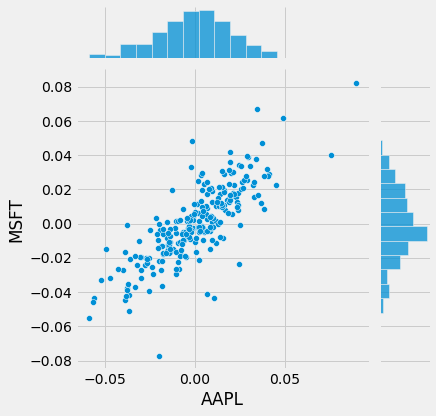

In [67]:
sns.jointplot(x='AAPL', y='MSFT', data=tech_rets, kind='scatter')

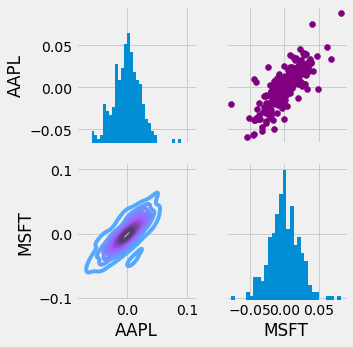

In [70]:
return_fig = sns.PairGrid(tech_rets.dropna())

return_fig.map_upper(plt.scatter, color='purple')

return_fig.map_lower(sns.kdeplot, cmap='cool_d')

return_fig.map_diag(plt.hist, bins=30)

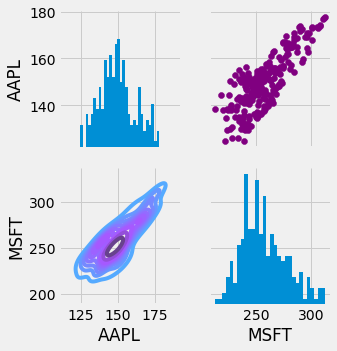

In [71]:
returns_fig = sns.PairGrid(closing_df)

returns_fig.map_upper(plt.scatter,color='purple')

returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

returns_fig.map_diag(plt.hist,bins=30)

In [72]:
tech_rets.corr()

,AAPL,MSFT
AAPL,1.000000,0.803193
MSFT,0.803193,1.000000


In [74]:
closing_df.corr()

,AAPL,MSFT
AAPL,1.000000,0.821839
MSFT,0.821839,1.000000


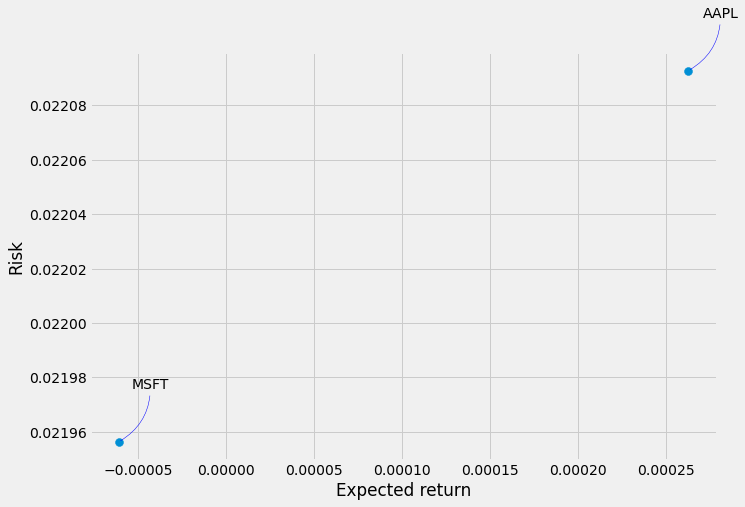

In [75]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 7))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

There is a strong linear relationship between the closing prices and daily returns of Apple and Microsoft stocks. As previously mentioned, AAPL has a slightly higher average daily return and slightly higher standard deviation.

## 3. Scaling and Splitting Data for Modelling

10 years of Apple stock data are downloaded and visualized before scaling with a minmax scaler, and the data is split into training and validation datasets.

In [76]:
#Download 10 years of data for AAPL
start = datetime(end.year - 10, end.month, end.day)

globals()['Pred_AAPL'] = yf.download('AAPL', start, end)

[*********************100%***********************]  1 of 1 completed


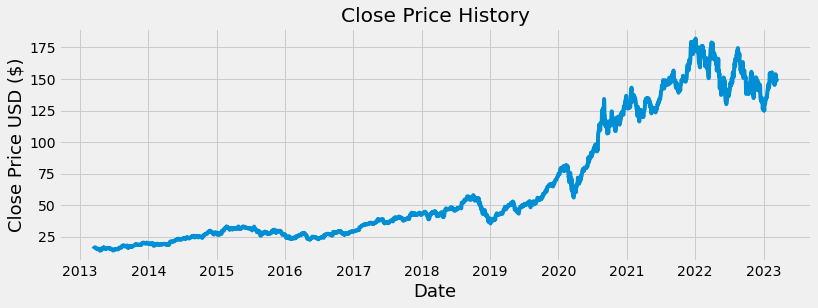

In [83]:
plt.figure(figsize=(12,4))
plt.title('Close Price History')
plt.plot(Pred_AAPL['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [84]:
# Create a new dataframe with only the 'Close column 
data = Pred_AAPL.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2392

In [85]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00891888],
       [0.01129044],
       [0.01385327],
       ...,
       [0.81304575],
       [0.80060992],
       [0.81233176]])

In [86]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00891888, 0.01129044, 0.01385327, 0.01359189, 0.01307974,
       0.01321787, 0.01516868, 0.01552356, 0.01500505, 0.01307974,
       0.01107794, 0.00815598, 0.00834298, 0.0088105 , 0.00790309,
       0.00694257, 0.00758221, 0.00774584, 0.00959677, 0.00930777,
       0.00834511, 0.00623068, 0.00758859, 0.00260744, 0.00032301,
       0.        , 0.00172979, 0.0033151 , 0.00317271, 0.00379323,
       0.00566753, 0.00841311, 0.01110343, 0.01036179, 0.01168571,
       0.01263348, 0.01491368, 0.01447803, 0.01557881, 0.01407639,
       0.01326887, 0.013645  , 0.01133295, 0.00814322, 0.00936088,
       0.00908038, 0.01113531, 0.01044042, 0.01079955, 0.01096743,
       0.01160708, 0.01081867, 0.01156457, 0.01297349, 0.01258036,
       0.01279074, 0.0124911 , 0.01159858, 0.01018541, 0.01089731])]
[0.010276786271706168]

[array([0.00891888, 0.01129044, 0.01385327, 0.01359189, 0.01307974,
       0.01321787, 0.01516868, 0.01552356, 0.01500505, 0.01307974,
       0.01107794, 0.00815598, 0.0

## 4. LSTM Closing Price Prediction

In [90]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2332/2332 [==============================] - 49s 20ms/step - loss: 0.0019


In [91]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

4/4 [==============================] - 1s 23ms/step


5.441745193323621

C:\Users\darre\AppData\Local\Temp\ipykernel_14672\2388977846.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


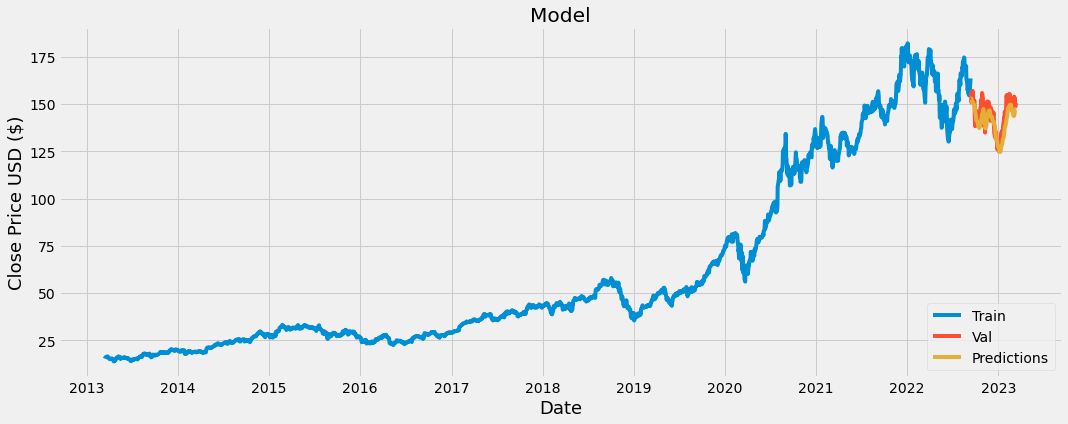

In [92]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

C:\Users\darre\AppData\Local\Temp\ipykernel_14672\2212747289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


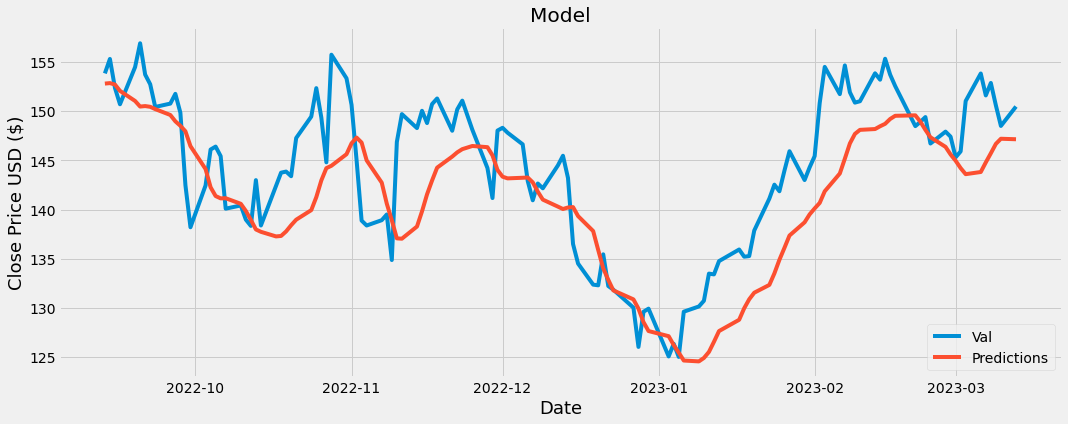

In [93]:
# Plot the data for only the predicted dates
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)

plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()